In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c
from scipy.special import wofz

from astro530 import partition, saha_phi, P_e, K_total, KH_bf, KH_ff, KHminus_bf, KHminus_ff, K_e

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

e = c.e.esu

In [2]:
u_table = pd.read_table('./data/RepairedPartitionFunctions.txt', header=None, na_values='-', delim_whitespace=True)
u_table = u_table.set_index(0)

i_table = pd.read_table('./data/nist_ioniz.txt', header=None , delim_whitespace= True)
i_table = i_table.set_index(1)

A_table = pd.read_table('./data/SolarAbundance.txt', delim_whitespace= True)
A_table.dropna(inplace=True)

elements = A_table['element'].to_list()
elements.remove('Cs')

A_table = A_table.set_index('element')

VALIIIC = np.loadtxt('./data/VALIIIC_sci_e.txt').T

In [3]:
weight = A_table['weight']
m_Na = weight['Na'] * u.u

I_Na = i_table.loc['Na'][3] * u.eV

In [4]:
def gamma_4(log_C4, Pe, T):
    Pe = Pe / u.barye
    T = T / u.K
    log_gamma4 = 19 + 2/3 * log_C4 + np.log10(Pe) - 5/6 * np.log10(T)
    return 10 ** log_gamma4 * 1/u.s

def C_6(l0, I):
    chi_l = (c.h * c.c / l0).to(u.eV).value
    I = I.to(u.eV).value
    C6 = 0.3e-30 * (1/(I - chi_l)**2 - 1/I**2)
    return C6

def gamma_6(C6, Pg, T):
    Pg = Pg / u.barye
    T = T / u.K
    log_gamma6 = 20 + 0.4 * np.log10(C6) + np.log10(Pg) - 0.7 * np.log10(T)
    return 10 ** log_gamma6 * 1/u.s

def gamma(l0, Pg, Pe, T, A_ul, log_C4, I = I_Na):
    gamma_rad = A_ul
    gamma4 = gamma_4(log_C4, Pe, T)
    gamma6 = gamma_6(C_6(l0, I), Pg, T)
    
    return gamma_rad + gamma4 + gamma6

In [5]:
def delta_nuD(nu0, T, micro):
    therm = 2 * c.k_B * T / m_Na
    return nu0 / c.c * np.sqrt(therm + micro**2)

In [6]:
def H_a(g, D_nu_D):
    return g /(4 * np.pi * D_nu_D)

def H_u(nu, nu0, D_nu_D):
    return (nu - nu0) / D_nu_D

In [7]:
def Voigt(u, a, Dnu):
    return np.real(wofz(u + 1j*a)) / (np.sqrt(np.pi) * Dnu) 

In [8]:
def osc_f(l, g_l, g_u, A):
    A_gray = A / (4 * np.pi)
    l = l.to(u.AA).value
    return 1.884e-15 * g_u / g_l * l**2 * A_gray.value

def alpha_line(l, l0, T, Pg, Pe, A_ul, g_l, g_u, log_C4, micro):
    nu0 = c.c / l0
    nu = c.c / l
    
    g = gamma(l0, Pg, Pe, T, A_ul, log_C4).to(u.Hz)
    Dnu = delta_nuD(nu0, T, xi_micro).to(u.Hz)
    
    a = H_a(g, Dnu)
    v = H_u(nu, nu0, Dnu)
    
    f = osc_f(l, g_l, g_u, A_ul)
    
    return Voigt(v, a, Dnu) * np.pi * e**2/(c.m_e * c.c) * f

In [9]:
tau_500 = VALIIIC[2]

T = VALIIIC[3][48] * u.K
Pg = VALIIIC[7][48] * VALIIIC[8][48] * u.barye
Pe = P_e(T, Pg, A_table, i_table, u_table, elements)
xi_micro = VALIIIC[4][48] * u.km/u.s
rho = VALIIIC[9][48] * u.g/u.cm**3
nH = nH = VALIIIC[5][48] * u.cm**-3

In [10]:
wvlen = np.linspace(5876, 5911, 1000) * u.AA
log_C4 = np.array([-15.17, -15.33])
A_ul = np.array([0.616, 0.614]) * 10**8 * 1/u.s
g_l = np.array([2, 2])
g_u = np.array([2, 4])

wvlen_0 = np.array([5889.959, 5895.932]) * u.AA

In [11]:
nu0 = c.c / wvlen_0
Dlambda = c.c / nu0**2 * (delta_nuD(nu0, T, xi_micro))
for i in range(2):
    print('lambda_0 = ' + str(wvlen_0[i]))
    print('log(gamma_4) = ' + '{:.2f}'.format(np.log10(gamma_4(log_C4, Pe, T).value)[i]))
    print('log(gamma_6) = ' + '{:.2f}'.format(np.log10(gamma_6(C_6(wvlen_0, I_Na), Pg, T).value)[i]))
    print('Dlambda_D = ' + '{:.4f}'.format(Dlambda.to(u.AA)[i].value))
    print('Stim. emission factor = ' + '{:.3f}'.format(1 - np.exp(-c.h * c.c / (wvlen_0[i] * c.k_B * T))))
    print('\n')

lambda_0 = 5889.959 Angstrom
log(gamma_4) = 7.46
log(gamma_6) = 9.72
Dlambda_D = 0.0527
Stim. emission factor = 0.978


lambda_0 = 5895.932 Angstrom
log(gamma_4) = 7.36
log(gamma_6) = 9.72
Dlambda_D = 0.0528
Stim. emission factor = 0.978




Text(0.5, 0, '$\\lambda [\\AA]$')

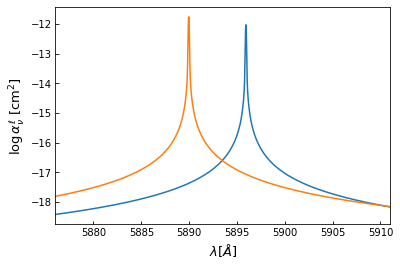

In [12]:
alpha_D2 = alpha_line(wvlen, wvlen_0[0], T, Pg, Pe, A_ul[0], 2, 4, log_C4[0], xi_micro).cgs.value
alpha_D1 = alpha_line(wvlen, wvlen_0[1], T, Pg, Pe, A_ul[1], 2, 2, log_C4[1], xi_micro).cgs.value

plt.plot(wvlen, np.log10(alpha_D1))
plt.plot(wvlen, np.log10(alpha_D2))
plt.ylabel(r'$\log \alpha^\ell_\nu$ [cm$^2$]')
plt.xlabel(r'$\lambda [\AA]$')

In [13]:
A_Na = A_table['A']['Na']
f_e = 2/partition('Na', T, u_table)
print('Ground fraction: {:.4f}'.format(f_e))
Phi_Na = saha_phi('Na', T, i_table, u_table)

f_i = 1 / (1 + Phi_Na / Pe)
print('Neutral fraction: {:.3e}'.format(f_i))

def K_NaD1(l):
    alpha = alpha_line(l, wvlen_0[1], T, Pg, Pe, A_ul[1], 2, 2, log_C4[1], xi_micro).cgs 
    stim = 1 - np.exp(-c.h * c.c / (l * c.k_B * T))
    return alpha * nH / rho * A_Na * f_e * f_i * stim

def K_NaD2(l):
    alpha = alpha_line(l, wvlen_0[0], T, Pg, Pe, A_ul[0], 2, 4, log_C4[0], xi_micro).cgs 
    stim = 1 - np.exp(-c.h * c.c / (l * c.k_B * T))
    return alpha * nH / rho * A_Na * f_e * f_i * stim

Ground fraction: 0.8635
Neutral fraction: 6.375e-04


In [14]:
A_j = A_table.loc[elements]['A'].to_numpy()
mu = np.sum(A_table.loc[elements]['A'] * A_table.loc[elements]['weight'] * u.u).cgs

def to_cm2g(K, T, Pe, mu, H=True):
    if H:
        Phi_H = saha_phi('H', T, i_table, u_table)
        neutral_H = 1 / (1 + Phi_H / Pe)
        K *= neutral_H 
    per_g = K / mu
    return per_g

In [15]:
naD1 = K_NaD1(wvlen).cgs.value
naD2 = K_NaD2(wvlen).cgs.value

continuum = u.Quantity([K_total(wvlen[i], T, Pg, Pe, A_table, i_table, u_table, elements) for i in range(len(wvlen))]).cgs.value

Hbf = to_cm2g(KH_bf(wvlen, T, i_table), T, Pe, mu).cgs.value
Hff = to_cm2g(KH_ff(wvlen, T, i_table), T, Pe, mu).cgs.value
Hminus_bf = to_cm2g(KHminus_bf(wvlen, T, Pe), T, Pe, mu).cgs.value
Hminus_ff = to_cm2g(KHminus_ff(wvlen, T, Pe), T, Pe, mu).cgs.value
electrons = to_cm2g(K_e(Pg, Pe, A_j), T, Pe, mu, H=False).cgs.value

In [18]:
l = np.array([5889.959, 5893, 5895.932]) * u.AA

K_NaD1_l = K_NaD1(wvlen).cgs.value
K_NaD2_l = K_NaD2(wvlen).cgs.value

print('\t '.join(['{:.0f}'.format(l[i].value) for i in range(3)]))
print(' '.join(['{:.2e}'.format(K_NaD1_l[i]) for i in range(3)]))
print(' '.join(['{:.2e}'.format(K_NaD2_l[i]) for i in range(3)]))
print('\n')

Kc = u.Quantity([K_total(l[i], T, Pg, Pe, A_table, i_table, u_table, elements, verbose=True) for i in range(len(l))]).cgs.value

5890	 5893	 5896
1.89e-04 1.90e-04 1.90e-04
7.73e-04 7.77e-04 7.81e-04


K(continuum) = 0.7878 cm2 / g
K(H-_bf) = 0.7411 cm2 / g
K(H-_ff) = 0.04878 cm2 / g
K(H_bf) = 0.01268 cm2 / g
K(H_ff) = 0.0004507 cm2 / g
K(e-) = 0.000157 cm2 / g


K(continuum) = 0.7881 cm2 / g
K(H-_bf) = 0.7414 cm2 / g
K(H-_ff) = 0.04882 cm2 / g
K(H_bf) = 0.0127 cm2 / g
K(H_ff) = 0.0004513 cm2 / g
K(e-) = 0.000157 cm2 / g


K(continuum) = 0.7885 cm2 / g
K(H-_bf) = 0.7417 cm2 / g
K(H-_ff) = 0.04886 cm2 / g
K(H_bf) = 0.01272 cm2 / g
K(H_ff) = 0.000452 cm2 / g
K(e-) = 0.000157 cm2 / g




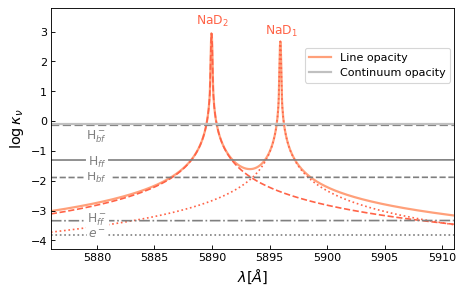

In [17]:
plt.figure(figsize=(6.5,4), dpi=80)
plt.plot(wvlen, np.log10(naD1),c='tomato', ls=':')
plt.text(5890, 3.25, 'NaD$_2$', ha='center', color='tomato', size=11)

plt.plot(wvlen, np.log10(naD2),c='tomato', ls='--')
plt.text(5896, 2.9, 'NaD$_1$', ha='center', color='tomato', size=11)

plt.plot(wvlen, np.log10(naD1 + naD2), c='lightsalmon', lw=2, zorder=0, label =r'Line opacity')

plt.plot(wvlen, np.log10(Hbf), 'C7--')
plt.text(5880, -2, r'H$_{bf}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))

plt.plot(wvlen, np.log10(Hff), 'C7-.')
plt.text(5880, -1.5, r'H$_{ff}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))

plt.plot(wvlen, np.log10(Hminus_bf),'C7--', lw=2)
plt.text(5880, -0.6, r'H$^-_{bf}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white', alpha=0.8))

plt.plot(wvlen, np.log10(Hminus_ff),'C7-')
plt.text(5880, -3.4, r'H$^-_{ff}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))

plt.hlines(np.log10(electrons), 5876, 5911, 'C7', ':')
plt.text(5880, -3.95, r'$e^-$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))

plt.plot(wvlen, np.log10(continuum), c='silver', ls = '-', label =r'Continuum opacity',lw=2)

#plt.plot(wvlen, np.log10(naD1 + naD2 + continuum), 'k-', lw=1, label =r'$\kappa_{tot}$')
plt.ylabel(r'$\log \kappa_\nu$')
plt.xlabel(r'$\lambda [\AA]$')

plt.ylim(-4.3, 3.8)

plt.legend(loc = (0.63, 0.69))

plt.savefig('NaD_kappa.png', bbox_inches='tight')
plt.show()